# DEA CoastLines vector statistics

## Background


## Description



## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as dcl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_spatialtools import subpixel_contours

## Load in data

In [200]:
# Read in contours
study_area = 8531
output_name = 'nswqld'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2018'


## Load DEA CoastLines rasters

In [201]:
yearly_ds = dcl_stats.load_rasters(output_name, study_area, water_index)
print(yearly_ds)

# Create output vector folder
output_dir = f'output_data/{study_area}_{output_name}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

<xarray.Dataset>
Dimensions:         (x: 1647, y: 1811, year: 31)
Coordinates:
  * x               (x) float64 5.182e+05 5.182e+05 ... 5.676e+05 5.676e+05
  * y               (y) float64 -3.082e+06 -3.082e+06 ... -3.137e+06 -3.137e+06
  * year            (year) int64 1988 1989 1990 1991 ... 2015 2016 2017 2018
Data variables:
    mndwi           (year, y, x) float32 -0.31058383 -0.30045307 ... 0.41537791
    gapfill_index   (year, y, x) float32 -0.36271185 -0.4189167 ... 0.43478262
    gapfill_tide_m  (year, y, x) float32 -0.032889735 ... -0.024983967
    gapfill_count   (year, y, x) int16 12 12 11 13 14 13 ... 61 60 60 62 59 61
    stdev           (year, y, x) float32 0.25311634 0.2451177 ... 0.24500887
    tide_m          (year, y, x) float32 -0.1913479 -0.19127005 ... -0.03961233
    count           (year, y, x) int16 4 4 3 4 5 4 3 3 ... 28 29 29 29 30 28 30
Attributes:
    crs:        +init=epsg:32656
    transform:  | 30.00, 0.00, 518205.00|\n| 0.00,-30.00,-3082395.00|\n| 0.00...


## Load vector data

In [202]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', 
                               bbox=bbox).to_crs(yearly_ds.crs))

# Tide points
points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', 
                            bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
comp_gdf = (gpd.read_file('input_data/50km_albers_grid.shp', bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')

/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is d

## Extract shoreline contours

### Extract ocean-masked contours

In [204]:
yearly_ds = yearly_ds.isel(x=slice(900, 1400), y=slice(1050,1550))
# yearly_ds = yearly_ds.isel(x=slice(1000, 1500), y=slice(100,500))

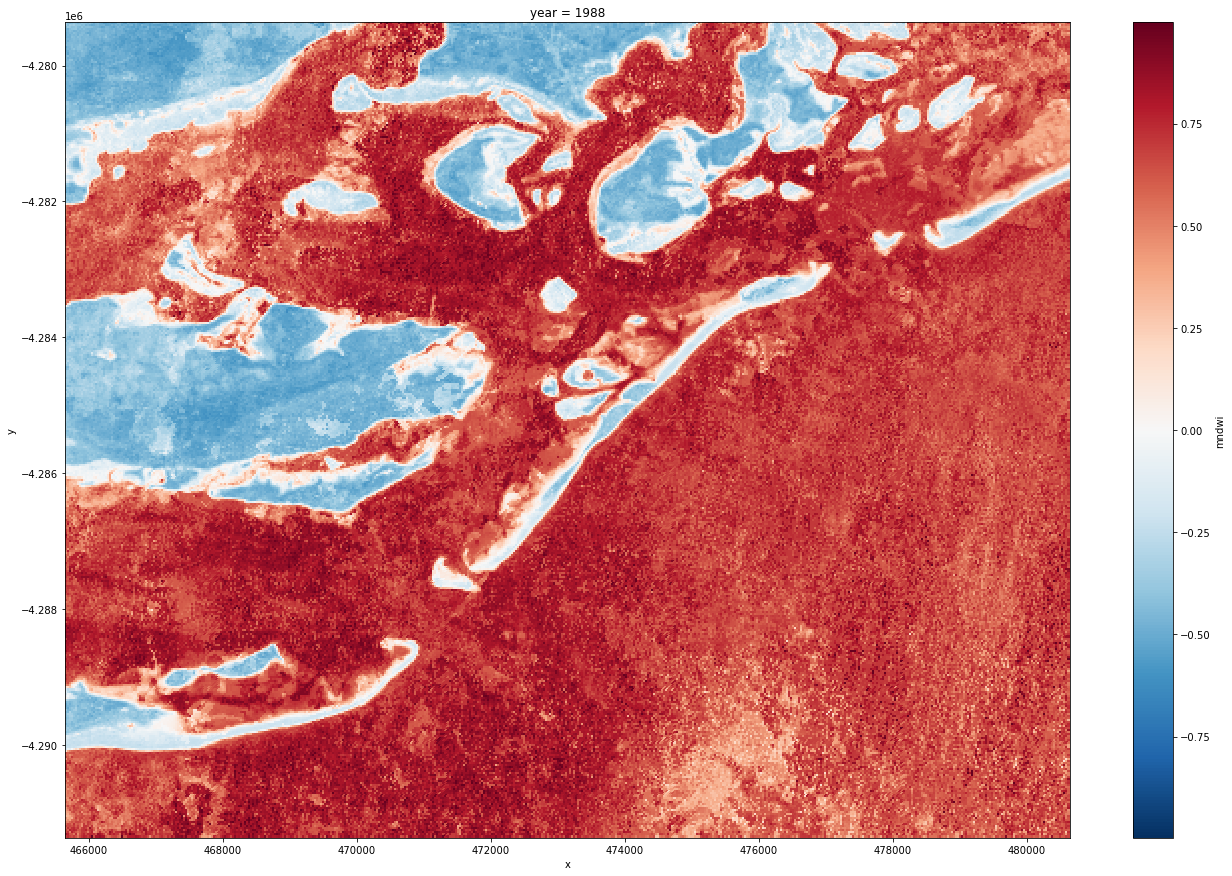

In [134]:
# yearly_ds.isel(x=slice(1000, 1500), y=slice(100,500), year=0).mndwi.plot(size=15)

In [253]:
# Generate waterbody mask
waterbody_array = dcl_stats.waterbody_mask(
    input_data='input_data/SurfaceHydrologyPolygonsRegional.gdb',
    modification_data='input_data/estuary_mask_modifications.geojson',
    bbox=bbox,
    yearly_ds=yearly_ds)

# Mask dataset to focus on coastal zone only
masked_ds = dcl_stats.contours_preprocess(
    yearly_ds,
    water_index,
    index_threshold,
    waterbody_array,
    points_gdf,
    output_path=f'output_data/{study_area}_{output_name}')

/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/g/data/v10/public/modules/dea-env/20200313/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, ax

In [254]:
# Extract contours
contours_gdf = subpixel_contours(da=masked_ds,
                                 z_values=index_threshold,
                                 min_vertices=30,
                                 dim='year',
                                 output_path='temp.geojson').set_index('year')

Operating in single z-value, multiple arrays mode


/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Writing contours to temp.geojson


## Compute statistics
### Create stats points on baseline contour

In [7]:
# Extract statistics modelling points along baseline contour
points_gdf = dcl_stats.stats_points(contours_gdf, baseline_year, distance=30)

# Clip to remove rocky shoreline points
points_gdf = dcl_stats.rocky_shores_clip(points_gdf, smartline_gdf, buffer=50)


### Measure annual coastline movements

In [8]:
if points_gdf is not None:
    
    # Make a copy of the points GeoDataFrame to hold tidal data
    tide_points_gdf = points_gdf.copy()

    # Calculate annual movements and residual tide heights for every contour
    # compared to the baseline year
    points_gdf, tide_points_gdf = dcl_stats.annual_movements(yearly_ds, 
                                                             points_gdf, 
                                                             tide_points_gdf, 
                                                             contours_gdf, 
                                                             baseline_year,
                                                             water_index)

### Calculate regressions

In [9]:
if points_gdf is not None:

    points_gdf = dcl_stats.calculate_regressions(yearly_ds, 
                                                 points_gdf, 
                                                 tide_points_gdf, 
                                                 climate_df)

Comparing annual movements with time
Comparing annual movements with tide heights
Comparing annual movements with SOI
Comparing annual movements with IOD
Comparing annual movements with SAM
Comparing annual movements with IPO
Comparing annual movements with PDO


/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


## Export files

### Export stats files

In [10]:
if points_gdf is not None:

    # Clip stats to study area extent, remove rocky shores
    stats_path = f'{output_dir}/stats_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp')

### Export contours

In [52]:
# # Assign certainty to contours based on underlying masks
# contours_gdf = dcl_stats.contour_certainty(contours_gdf, 
#                                            output_path=f'output_data/{study_area}_{output_name}')

# # # Clip annual shoreline contours to study area extent
# contour_path = f'{output_dir}/contours_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
# contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
# contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
#                                                        driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
contours_gdf.reset_index().to_file(f'{contour_path}.shp')

### Copy all GeoJSON to folder

In [ ]:
!find /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/ -type f -path '*_refactor/vectors/*geojson' -exec cp -u '{}' /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/geojson/ ';'

In [ ]:
!find /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/ -type f -path '*ntwa/all_time_mask.tif' -exec cp -u '{}' /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/geojson/ ';'

### Merge GeoJSON

In [ ]:
import glob
glob.glob('output_data/*/vectors/shapefiles/contours_*_ntwa_mndwi_0.00.shp')[0:5]

In [ ]:
!ogrmerge.py -o DEACoastLines_coastlines_tasvicsa.shp output_data/*/vectors/shapefiles/contours_*_tasvicsa_mndwi_0.00.shp -single -overwrite_ds

In [ ]:
!ogrmerge.py -o DEACoastLines_statistics_tasvicsa.shp output_data/*/vectors/shapefiles/stats_*_tasvicsa_mndwi_0.00.shp -single -overwrite_ds

In [ ]:
!gdalwarp output_data/*nswqld/all_time_mask.tif mask_nswqld.tif -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024

In [ ]:
summary_gdf = dcl_stats.stats_points(contours_gdf, '2018', distance=2000)

In [ ]:
summary_gdf.plot()

In [ ]:
distance = 5000

# Set annual shoreline to use as a baseline
baseline_contour = contours_gdf.loc[['2018']].geometry

# # If multiple features are returned, take unary union
if baseline_contour.shape[0] > 0:
    baseline_contour = baseline_contour.unary_union
else:
    baseline_contour = baseline_contour.iloc[0]

# Generate points along line and convert to geopandas.GeoDataFrame
points_line = [baseline_contour.interpolate(i) 
               for i in range(0, int(baseline_contour.length), distance)]
points_gdf = gpd.GeoDataFrame(geometry=points_line, crs=contours_gdf.crs)


In [ ]:
points_test = points_gdf.head(100)
points_test['geometry'] = points_test.buffer(10000)
points_test.plot()

In [ ]:
stats_gdf = gpd.read_file('DEACoastLines_statistics_ntwa.shp')

In [ ]:
points_test.loc[0]

In [ ]:
gpd.clip(stats_gdf, points_test.loc[[0]])

In [ ]:
points_test = points_gdf
points_test['geometry'] = points_test.buffer(10000)
points_test.plot()

In [ ]:
from shapely.geometry import shape

polygons = points_test.geometry
points = stats_gdf.geometry

# Create the R-tree index and store the features in it (bounding box)
from rtree import index
idx = index.Index()
for pos, poly in enumerate(polygons):
    idx.insert(pos, poly.bounds)

out_dict = {}
    
#iterate through points
for i, point in enumerate(points):
            
    poly_idx = [j for j in idx.intersection((point.coords[0]))
                if point.within(polygons[j])]
    
    if len(poly_idx) > 0:
        out_dict[i] = poly_idx
        

In [ ]:
new_dict = {}
for k,v in out_dict.items():
    for x in v:
        new_dict.setdefault(x,[]).append(k)

In [ ]:
def get_matching_data(key):
    try:
        
        matching_points = stats_gdf.iloc[new_dict[key]].copy()
        
        # Set nonsignificant to 0
        matching_points.loc[matching_points.sig_time > 0.01, 'rate_time'] = 0  
        
        return matching_points.rate_time.mean()
    
    except:
        return None

points_test['summary'] = points_test.apply(lambda row: get_matching_data(row.name), axis=1)



# int(points_test.iloc[0].name)

In [ ]:
points_test.summary.min()

In [ ]:
points_test.plot(column='summary', figsize=(10, 20), cmap='RdBu', vmin=-1, vmax=1)

In [ ]:
points_test['geometry'] = points_test.centroid
points_test.to_file('summary_ntwa.shp')

In [ ]:
stats_gdf.iloc[new_dict[1898]].rate_time.mean()

In [ ]:
import matplotlib.pyplot as plt
points_test.iloc[[1898]].plot()
stats_gdf.iloc[new_dict[1898]].plot(ax=plt.gca(), color='red')


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020